In [2]:
import os

CHEMIN = "/Users/walazerelli/tac-25-26/data/txt"  # ton dossier
ANNEE_CHOISIE = "1923"  # année à analyser

texte_total = ""
fichiers_trouves = 0

for fichier in os.listdir(CHEMIN):
    if fichier.endswith(".txt") and ANNEE_CHOISIE in fichier:
        chemin_fichier = os.path.join(CHEMIN, fichier)
        try:
            with open(chemin_fichier, "r", encoding="utf-8", errors="ignore") as f:
                contenu = f.read().strip()
                if contenu:
                    texte_total += " " + contenu.lower()
                    fichiers_trouves += 1
        except Exception as e:
            print(f"Impossible de lire {fichier}: {e}")

print(f"Fichiers lus pour l'année {ANNEE_CHOISIE} : {fichiers_trouves}")
if not texte_total:
    raise ValueError("Aucun texte trouvé pour cette année !")


Fichiers lus pour l'année 1923 : 100


In [3]:
import re

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"[\d]", " ", s)
    s = re.sub(r"[\-—–_/\\]", " ", s)
    s = re.sub(r"[.,;:!?()\[\]{}'\"«»“”]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

texte_total_clean = normalize_text(texte_total)
texts = [texte_total_clean]  # liste d’un seul élément


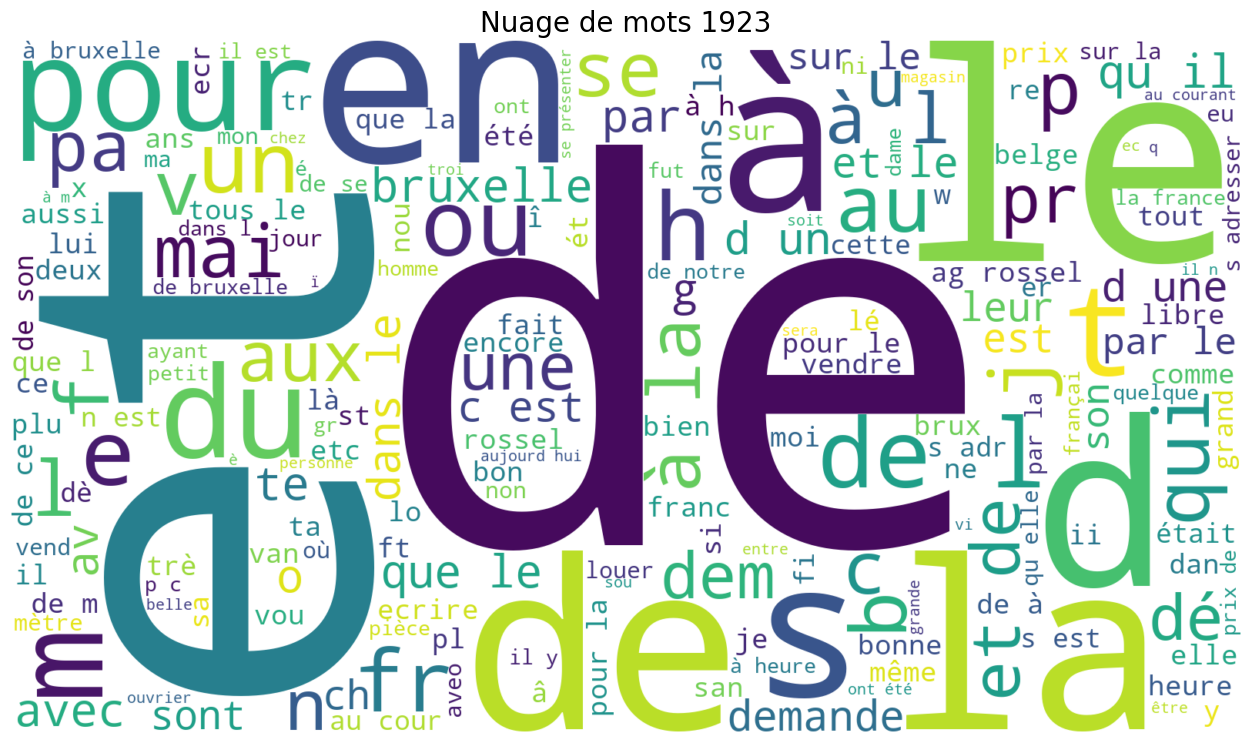

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS) | {"rue","avenue","place","maison","ville","tél","tel","agence","article","journal"}
texte_nuage = texte_total_clean  # texte nettoyé

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    stopwords=stopwords,
    colormap="viridis"
).generate(texte_nuage)

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"Nuage de mots {ANNEE_CHOISIE}", fontsize=20)
plt.show()

wc.to_file(f"wordcloud_{ANNEE_CHOISIE}.png")

In [4]:
import pandas as pd
import yake

def extract_keywords_yake(docs, topk=200, max_ngram=3):
    kw_extractor = yake.KeywordExtractor(lan="fr", n=max_ngram, top=topk)
    joined = "\n".join(docs)
    keywords = kw_extractor.extract_keywords(joined)
    df = pd.DataFrame(keywords, columns=["keyword","score"]).sort_values("score")
    return df

def clean_keywords(df, stopset):
    cleaned, seen = [], set()
    for kw, score in df.values:
        k = " ".join([w for w in normalize_text(kw).split() if w not in stopset and len(w) > 2])
        if not k or k in seen:
            continue
        seen.add(k)
        cleaned.append((k, score))
    return pd.DataFrame(cleaned, columns=["keyword","score"]).sort_values("score")

STOPWORDS = {"rue","avenue","place","maison","ville","tél","tel","agence","article","journal"}
kw_df_raw = extract_keywords_yake(texts)
kw_df_clean2 = clean_keywords(kw_df_raw, STOPWORDS)
print("Top 10 mots-clés :", kw_df_clean2.head(10))


Top 10 mots-clés :                  keyword         score
0             bons gages  7.279495e-10
1        dem jeune fille  1.031053e-09
2       rossel bruxelles  1.174996e-09
3        dem bon ouvrier  1.505030e-09
4      dem bons ouvriers  1.641851e-09
5               bas prix  2.557036e-09
6  demande bons ouvriers  2.645904e-09
7        neuve bruxelles  2.786640e-09
8           dem bon demi  2.813299e-09
9              haut prix  3.460650e-09


In [6]:
import spacy

nlp = spacy.load("fr_core_news_md")
nlp.max_length = 5_000_000  # permet d’éviter E088 sur texte long

CHUNK_SIZE = 100_000  # découpe pour éviter crash

def norm_ent(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"^[\"'«»“”()\[\]{},.:;!?-]+|[\"'«»“”()\[\]{},.:;!?-]+$", "", s)
    return s

ENT_STOP = {"dem","bur","adr","fem","mén","ec","av","tel","tél","ag","rossel","agence rossel",
            "mm","mr","mme","m.","s.","st","bd","n°","no","rue","avenue","place","bureau"}

ents_list = []

for i in range(0, len(texte_total_clean), CHUNK_SIZE):
    chunk = texte_total_clean[i:i+CHUNK_SIZE]
    doc = nlp(chunk, disable=["tagger","lemmatizer","morphologizer"])
    for e in doc.ents:
        if e.label_ in ("PERSON","ORG","GPE"):
            ents_list.append((e.text.strip(), e.label_))

ner_df = pd.DataFrame(ents_list, columns=["text","label"])
ner_df["text_norm"] = ner_df["text"].apply(norm_ent)
ner_df["text_low"] = ner_df["text_norm"].str.lower()

mask_good = (
    (ner_df["text_norm"].str.len() >= 3) &
    (~ner_df["text_low"].isin(ENT_STOP)) &
    (~ner_df["text_norm"].str.fullmatch(r"[\W_]+")) &
    (~ner_df["text_norm"].str.fullmatch(r"\d+[\W_\d]*"))
)
ner_df_clean = ner_df[mask_good]

top_ents = (ner_df_clean.groupby(["label","text_norm"])
            .size().reset_index(name="count")
            .sort_values(["label","count"], ascending=[True, False]))
top20_by_label = top_ents.groupby("label").head(20).reset_index(drop=True)
print(top20_by_label)


   label         text_norm  count
0    ORG             reich     59
1    ORG              ford     23
2    ORG               hom     20
3    ORG               enf     13
4    ORG               tou     12
5    ORG       croix rouge     10
6    ORG              fiat     10
7    ORG       yougoslavie     10
8    ORG           anspach      9
9    ORG       congo belge      8
10   ORG           bruxell      7
11   ORG               eér      7
12   ORG       grand’place      7
13   ORG               iso      7
14   ORG               ter      7
15   ORG  banque nationale      6
16   ORG          connaiss      6
17   ORG               rep      6
18   ORG              benz      5
19   ORG               com      5


In [7]:
from textblob import TextBlob

# Découper en phrases
sentences = [s.text.strip() for s in nlp(texte_total_clean).sents if len(s.text.strip())>20]

top_keywords = set(kw_df_clean2["keyword"].head(50))
ent_terms = set(top20_by_label["text_norm"].head(50))

def relevance_score(sent):
    s_norm = normalize_text(sent)
    score = 0
    for kw in top_keywords:
        if kw in s_norm: score += 2
    for ent in ent_terms:
        if ent in s_norm: score += 3
    return score

scored = sorted([(s, relevance_score(s)) for s in sentences], key=lambda x: x[1], reverse=True)
selected, seen = [], set()
for s, sc in scored:
    sig = " ".join(normalize_text(s).split()[:8])
    if sig in seen or sc == 0:
        continue
    seen.add(sig)
    selected.append(s)
    if len(selected) == 10:
        break

# Analyse sentiment
rows = []
for i, s in enumerate(selected, 1):
    pol, subj = TextBlob(s).sentiment
    rows.append({"#": i, "phrase": s, "polarite": float(pol), "subjectivite": float(subj)})

sent_df = pd.DataFrame(rows)
print(sent_df)


    #                                             phrase  polarite  \
0   1  porte louise et porte de nnmur ecrira ft m d a...  0.000000   
1   2  prémédité son crime car un témoin entendu toe ...  0.266667   
2   3  cinema nous cherchons d’urgence débutants des ...  0.200000   
3   4  a b aider bureau entrer en i m béf et prêt l f...  0.000000   
4   5  le discours curzon de notre correspondant part...  0.227792   
5   6  urs voyageurs qui s’entassaient sur ia plate f...  0.068471   
6   7  fille* souffrant d’anémie chlorose faiblesse é...  0.100392   
7   8  sont demandées louis daerms montng aux herbes ...  0.000000   
8   9  bronchite l asthme des douleurs dans la poitri...  0.500000   
9  10  le matin consacre una nage entière à un relevé...  0.046387   

   subjectivite  
0      0.000000  
1      0.433333  
2      0.400000  
3      0.000000  
4      0.687143  
5      0.575799  
6      0.608627  
7      0.100000  
8      1.000000  
9      0.499068  
